In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy import io
from mne import viz, stats
from matplotlib import colors, cm, gridspec, offsetbox, pyplot as plt
from IPython.display import display

plt.style.use("seaborn-dark")
plt.rcParams.update({"xtick.labelsize": 18, "ytick.labelsize": 18, "savefig.facecolor": (1, 1, 1, 0)})

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05
AGE_GROUP = -1 # -1: all, 0: up to age 30, 1: from age 30

PROJECT_PATH = '../data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '../results/final/'
FIGURE_PATH = '../figures'
MODEL_DIR = f"multiML{CAF_DOSE}" # f"multiML{CAF_DOSE}" or f"logisticRegression{CAF_DOSE}"
TWO_SIDED_IMPORTANCES = False # set to true for logistic regression, false for random forest

STAGES = ['NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3', 'P4',
            'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']

# Load data

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
# get age suffix for loading the data depending on age group parameter
age_suffix = ''
if AGE_GROUP == 0:
    age_suffix = '_age_t30'
elif AGE_GROUP == 1:
    age_suffix = '_age_f30'
elif AGE_GROUP != -1:
    raise Exception(f"Unknown age group {AGE_GROUP}")

importances = {}
scores = {}
feature_names = {}

for stage in STAGES:
    with open(os.path.join(RESULTS_PATH, MODEL_DIR, f'importances-{stage}{age_suffix}.pickle'), 'rb') as file:
        importances[stage] = pickle.load(file)
    with open(os.path.join(RESULTS_PATH, MODEL_DIR, f'scores-{stage}{age_suffix}.pickle'), 'rb') as file:
        scores[stage] = pickle.load(file)
    with open(os.path.join(RESULTS_PATH, MODEL_DIR, f'feature_names-{stage}{age_suffix}.pickle'), 'rb') as file:
        feature_names[stage] = pickle.load(file)
    
    ########################
    ######## remove ########
    ########################
    feature_names[stage] = np.array([ft for ft in feature_names[stage] if "Uncorrected" not in ft])

In [5]:
importance_means = {}
importance_stds = {}
for stage in STAGES:
    importance_means[stage] = np.mean(importances[stage], axis=0)
    importance_stds[stage] = np.std(importances[stage], axis=0)

score_means = {}
score_stds = {}
for stage in STAGES:
    score_means[stage] = np.mean(scores[stage])
    score_stds[stage] = np.std(scores[stage])

FEATURES = ["PSD_delta", "PSD_theta", "PSD_alpha", "PSD_sigma", "PSD_beta",
            "SpecShanEn", "SampEn", "SpecSampEn", "LZiv", "DFA", "OneOverF"]

In [6]:
def fmt_feat(name):
    name = name.replace("PSD", "").replace('_', ' ').replace('Shan', '').replace("LZiv", "LZc").replace("OneOverF", f"aperiodic slope").replace("DFA", "scaling exponent")
    return name

# Create figures

In [7]:
feature_colors = {
    'PSD_delta': '#ff0000',
    'PSD_theta': '#ff5b00',
    'PSD_alpha': '#ff8a00',
    'PSD_sigma': '#ffb300',
    'PSD_beta': '#ffda00',
    'SpecShanEn': '#0000ff',
    'SampEn': '#0079ff',
    'SpecSampEn': '#00a8ff',
    'LZiv': '#00caf9',
    'DFA': '#00e992',
    'OneOverF': '#00ff00',
}

## Decoding accuracy

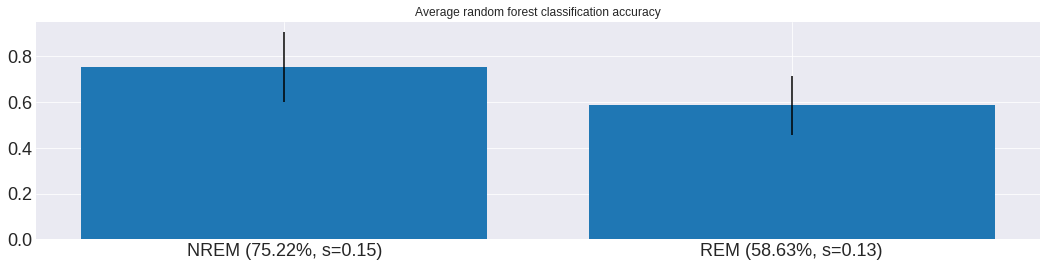

In [8]:
plt.figure(figsize=(18, 4))
plt.title('Average random forest classification accuracy')
plt.bar(np.arange(len(score_means)), score_means.values(), yerr=score_stds.values())

ticks = [stage.replace('AWSL', 'AWA') + f' ({acc*100:.2f}%, s={std:.2f})'
         for stage, acc, std in zip(STAGES, score_means.values(), score_stds.values())]
plt.xticks(np.arange(len(score_means)), ticks)
plt.grid()
plt.show()

## Top features table
Tables containing the top 10 features for each sleep stage, including the electrode name and absolute importance score.

In [9]:
pd.options.display.float_format = '{:,.3f}'.format

feature_categories = list(dict.fromkeys(map(lambda x: x.split("-")[0], feature_names[STAGES[0]])))

for stage in STAGES:
    # find the top features with corresponding channel name
    idxs = np.argsort(importance_means[stage])[::-1][:10]
    feat = [feature_categories[int(i / len(importance_means[stage]) * len(FEATURES))] for i in idxs]
    chs = [CHANNELS[i % 20] for i in idxs]

    # turn data into a pandas DataFrame for nice printing
    print(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'))
    display(pd.DataFrame(columns=["feature", "electrode", "importance"],
                         data=zip([fmt_feat(f) for f in feat],
                                  chs,
                                  importance_means[stage][idxs])))
    print()

non-REM


,feature,electrode,importance
0,LZc,P4,0.018
1,SpecSampEn,C3,0.018
2,SpecSampEn,Cz,0.018
3,LZc,F3,0.018
4,LZc,P3,0.016
5,LZc,Cz,0.016
6,LZc,F4,0.015
7,LZc,C3,0.015
8,LZc,Pz,0.014
9,LZc,Fz,0.014



REM


,feature,electrode,importance
0,theta,T3,0.014
1,scaling exponent,O1,0.013
2,SpecEn,O1,0.012
3,SpecEn,T5,0.011
4,theta,T6,0.011
5,theta,T4,0.010
6,sigma,C3,0.010
7,aperiodic slope,P3,0.010
8,scaling exponent,O2,0.010
9,theta,T5,0.010


## Feature importance maps
Shows full feature importance in the form of topomaps, in addition to colored bar plots.

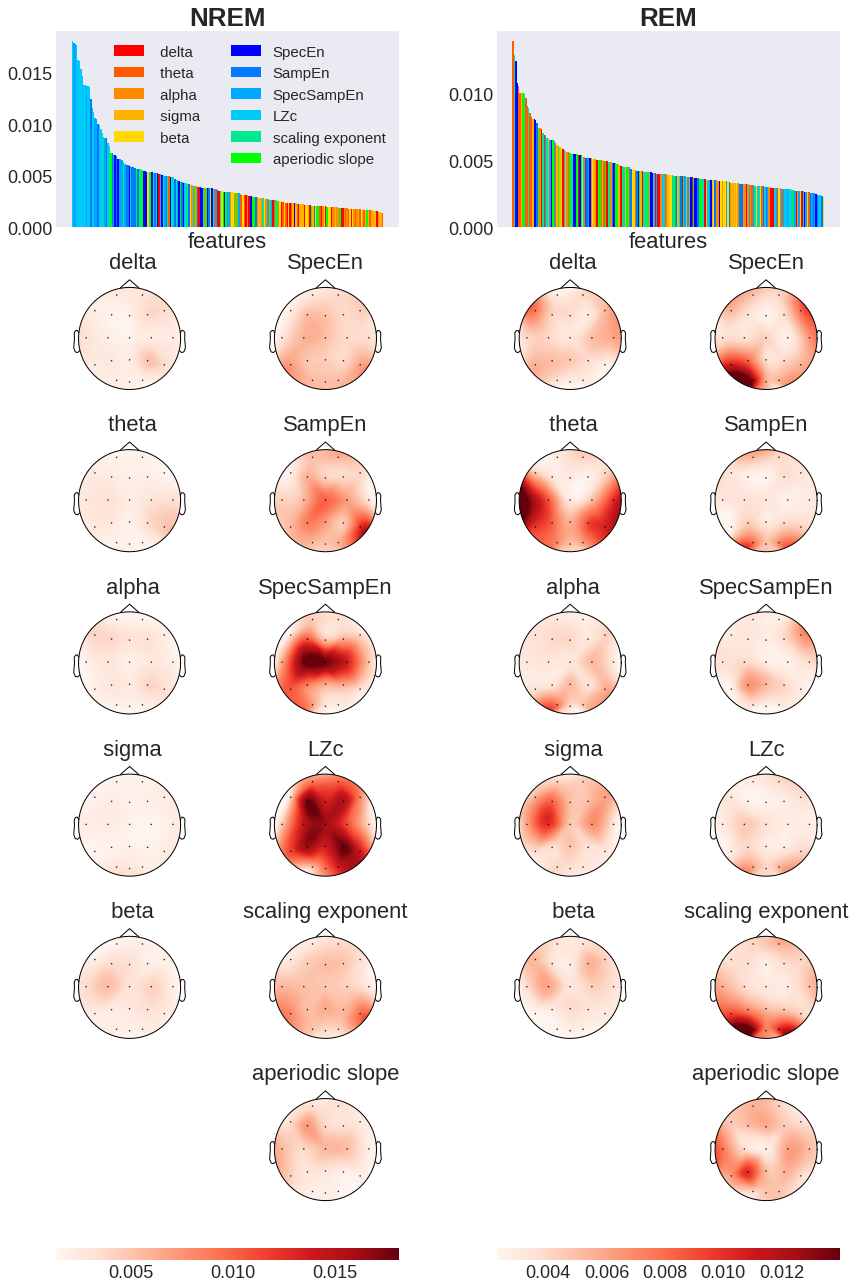

In [10]:
FEATURES_even = ["PSD_delta", "PSD_theta", "PSD_alpha", "PSD_sigma", "PSD_beta", "",
                 "SpecShanEn", "SampEn", "SpecSampEn", "LZiv", "DFA", "OneOverF"]
# groups feature importances by feature
importance = {}
for stage in STAGES:
    mean = importance_means[stage].reshape((-1, 20))
    features = [name.split('-')[0] for name in feature_names[stage][::20]]
    importance[stage] = dict([(feature, curr) for feature, curr in zip(features, mean)])

    
def barplot(ax, stage, legend=False, topn=-1):
    ax.patch.set_alpha(1)
    
    # get sorted indices for the importances
    indices = np.argsort(importance_means[stage])[::-1][:topn]

    # plot bars for each feature
    for category in FEATURES_even:
        if len(category) == 0:
            ax.bar([0], [0], label=" ", width=0, color=(0, 0, 0, 0))
            continue

        mask = [category in name for name in feature_names[stage][indices]]
        if np.sum(mask) > 0:
            name = fmt_feat(category)
            
            # plot bars of current feature
            ax.bar(np.arange(len(indices))[mask],
                   importance_means[stage][indices][mask],
                   label=name,
                   width=1,
                   color=feature_colors[category])
    ax.set_xticks([])
    ax.set_xlabel("features", fontsize=fontsize_big)
    if legend:
        ax.legend(fontsize=fontsize_small, loc="upper right", ncol=2)


fontsize_verybig = 26
fontsize_big = 22
fontsize_small = 15
cmap = "Reds"

n_feat = len(FEATURES_even)
fig, axes = plt.subplots(n_feat // 2 + 2, len(STAGES) * 2 + len(STAGES) - 1, figsize=(12, 18),
                         gridspec_kw=dict(width_ratios=([0.0, 1, 1] * len(STAGES))[1:],
                                          height_ratios=[1.7] + [1] * (n_feat // 2) + [0.11]))
gs = axes[0,0].get_gridspec()

# remove top and bottom row axes
for i in range(axes.shape[1]):
    axes[0, i].remove()
    axes[-1, i].remove()
# add combined bar plot and colorbar axes
barplot_axes, colorbar_axes = [], []
for i in range(len(STAGES)):
    if i > 0:
        for ax in axes[1:-1, i * 2]:
            ax.remove()
    barplot_axes.append(fig.add_subplot(gs[0, i * 2 + i : (i + 1) * 2 + i]))
    colorbar_axes.append(fig.add_subplot(gs[-1, i * 2 + i : (i + 1) * 2 + i]))

axes = axes[1:-1, ([False, True, True] * len(STAGES))[1:]]
for i_stage, stage in enumerate(STAGES):
    # add sleep stage title
    barplot_axes[i_stage].set_title(stage, weight="bold", fontsize=fontsize_verybig)
    
    # draw bar plots
    barplot(barplot_axes[i_stage], stage, legend=i_stage == 0)
    
    # draw topomaps
    vmin = min([min(importance[stage][feat]) for feat in FEATURES_even if len(feat) > 0])
    vmax = max([max(importance[stage][feat]) for feat in FEATURES_even if len(feat) > 0])

    for i_feat, feat in enumerate(FEATURES_even):
        ax = axes[i_feat % (n_feat // 2), i_feat // (n_feat // 2) + i_stage * 2]

        if len(feat) == 0:
            ax.axis("off")
            continue

        ax.set_title(fmt_feat(feat), fontsize=fontsize_big)
        viz.plot_topomap(importance[stage][feat],
                         sensor_pos,
                         axes=ax,
                         vmin=vmin,
                         vmax=vmax,
                         cmap=cmap,
                         contours=False,
                         show=False)
    
    mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    fig.colorbar(mappable, cax=colorbar_axes[i_stage], orientation="horizontal")
    
plt.tight_layout(w_pad=0, h_pad=0)
fname = "Figure4.pdf"
# transparent=True breaks the grey axes background but we set savefig.facecolor to transparent which does the trick
plt.savefig(os.path.join(FIGURE_PATH, fname), bbox_inches="tight")
plt.show()